In [2]:
import pandas as pd
import numpy as np
from plotnine import *
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, cohen_kappa_score
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC

### Data Import

In [3]:
myData = pd.read_csv("https://www.dropbox.com/s/s2a1uoiegitupjc/cannabis_full.csv?dl=1")
#data cleaning
myData = myData.dropna()
#myData.head()

### **Part One: Binary Classification**

**data wrangling**

In [147]:
data = myData[(myData["Type"] == "sativa") | (myData["Type"] == "indica")]
data.head()
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [148]:
X = myData.drop(columns=["Type"])
y = myData["Type"]

In [149]:
Xn = data.drop(columns=["Type"])
yn = data["Type"]

**Data metric choice**

As my metric to select my models I chose accuracy since there is no asymmetric cost to mispredicitng so striving for the most correct predictions seemed to be the best option. 

In [150]:

ct = ColumnTransformer(
    [
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown='ignore'), make_column_selector(dtype_include=object))
    ],
    remainder="passthrough"
).set_output(transform="pandas")

##### Q1: LDA

Please note for this and the following LDA's using the eigen paramter consistently fails, spoke with professor Glanz and we could not find a resolution. I left it included to show I tried it. Thank you :)

In [151]:
lda_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("lda", LinearDiscriminantAnalysis())
    ]
).set_output(transform="pandas")

params = {'lda__solver': ['svd', 'lsqr', 'eigen'],
          "lda__n_components": [1]
          }

grid_search = GridSearchCV(
    lda_pipeline,
    params,
    cv=stratified_cv,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(Xn, yn)

best_score = grid_search.best_score_
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")
print(f"Cross-validated Accuracy: {best_score:.2f}")

c:\Users\Evan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Evan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Evan\anaconda3\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Evan\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 475, in fit
    self._final_estimator.fit(Xt, y

Best parameters: {'lda__n_components': 1, 'lda__solver': 'svd'}
Cross-validated Accuracy: 0.80


In [152]:
lda_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("lda", LinearDiscriminantAnalysis(solver='svd', n_components=1))
    ]
).set_output(transform="pandas")

lda_pipeline.fit(Xn, yn)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000025F2DC18B30>)])),
                ('lda', LinearDiscriminantAnalysis(n_components=1))])

In [153]:
y_pred_lda = lda_pipeline.predict(Xn)
conf_matrix = confusion_matrix(yn, y_pred_lda)
class_names = ["indica", "sativa"]
conf_matrix_lda = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
conf_matrix_lda

,indica,sativa
indica,576,83
sativa,155,254


Using the svd solver the model achieved a cross validated accuracy of 80%

##### Q2: QDA

In [154]:
qda_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("qda", QuadraticDiscriminantAnalysis())
    ]
).set_output(transform="pandas")

params = {
    'qda__reg_param': [0.0, 0.01, 0.1, 0.5]
}

grid_search = GridSearchCV(
    qda_pipeline,
    params,
    cv=stratified_cv,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(Xn, yn)

best_score = grid_search.best_score_
best_params = grid_search.best_params_

print(f"Best parameters: {best_params}")
print(f"Cross-validated Accuracy: {best_score:.2f}")


Best parameters: {'qda__reg_param': 0.01}
Cross-validated Accuracy: 0.62


c:\Users\Evan\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear


In [155]:
qda_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("qda", QuadraticDiscriminantAnalysis(reg_param=0.0))
    ]
).set_output(transform="pandas")

qda_pipeline.fit(Xn, yn)

c:\Users\Evan\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000025F2DC18B30>)])),
                ('qda', QuadraticDiscriminantAnalysis())])

Using a regulation parameter of .01 the model achieved a cross validated accuracy of 62%

Confusion Matrix

In [156]:
y_pred_qda = qda_pipeline.predict(Xn)
conf_matrix = confusion_matrix(yn, y_pred_qda)
class_names = ["indica", "sativa"]
conf_matrix_qda = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
conf_matrix_qda

,indica,sativa
indica,659,0
sativa,0,409


##### Q3: SVC

In [157]:
svc_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("svc", SVC())  
    ]
).set_output(transform="pandas")

params = {
    'svc__C': [0.1, 1, 10, 100]
}

grid_search = GridSearchCV(
    svc_pipeline,
    params,
    cv=stratified_cv,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(Xn, yn)

best_score = grid_search.best_score_
best_params = grid_search.best_params_

print(f"Best parameters: {best_params}")
print(f"Cross-validated Accuracy: {best_score:.2f}")


Best parameters: {'svc__C': 10}
Cross-validated Accuracy: 0.86


In [158]:
svc_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("svc", SVC(C=10, kernel='poly'))
    ]
).set_output(transform="pandas")

svc_pipeline.fit(Xn, yn)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000025F2DC18B30>)])),
                ('svc', SVC(C=10, kernel='poly'))])

Using a  c of 10 the model achieved a cross validated accuracy of 86%

Confusion Matrix

In [159]:
y_pred_svc = svc_pipeline.predict(Xn)
conf_matrix = confusion_matrix(yn, y_pred_svc)
class_names = ["indica", "sativa"]
conf_matrix_svc = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
conf_matrix_svc

,indica,sativa
indica,659,0
sativa,0,409


##### Q4: SVM

In [160]:
svm_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("svc", SVC())
    ]
).set_output(transform="pandas")

params = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__kernel': ['poly']
}

grid_search = GridSearchCV(
    svm_pipeline,
    params,
    cv=stratified_cv,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(Xn, yn)

best_score = grid_search.best_score_
best_params = grid_search.best_params_

print(f"Best parameters: {best_params}")
print(f"Cross-validated Accuracy: {best_score:.2f}")

Best parameters: {'svc__C': 1, 'svc__kernel': 'poly'}
Cross-validated Accuracy: 0.87


In [163]:
svm_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("svc", SVC(C=1, kernel='poly'))
    ]
).set_output(transform="pandas")

svm_pipeline.fit(Xn, yn)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000025F2DC18B30>)])),
                ('svc', SVC(C=1, kernel='poly'))])

Using a  c of 1 and kernel = poly the model achieved a cross validated accuracy of 87%

Confusion Matrix

In [164]:
y_pred_svm = svm_pipeline.predict(Xn)
conf_matrix = confusion_matrix(yn, y_pred_svm)
class_names = ["indica", "sativa"]
conf_matrix_svm = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
conf_matrix_svm

,indica,sativa
indica,625,34
sativa,44,365


### **Part Two: Natural MultiClass**

##### Q1

In [165]:
dt_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("dt", DecisionTreeClassifier())
    ]
).set_output(transform="pandas")

params = {'dt__min_impurity_decrease': [0.0, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

grid_search = GridSearchCV(
    dt_pipeline,
    params,
    cv=stratified_cv,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X, y)

best_min_impurity_decrease = grid_search.best_params_['dt__min_impurity_decrease']
best_accuracy = grid_search.best_score_

print(f"Best min_impurity_decrease: {best_min_impurity_decrease}")
print(f"Best Accuracy: {best_accuracy}")


Best min_impurity_decrease: 0.01
Best Accuracy: 0.6138712932047722


In [166]:
dt_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("dt", DecisionTreeClassifier(min_impurity_decrease=0.01))
    ]
).set_output(transform="pandas")

In [167]:
dt_pipeline.fit(X, y)
y_pred_tree = dt_pipeline.predict(X)
conf_matrix = confusion_matrix(y, y_pred_tree)


In [169]:
feature_names = dt_pipeline.named_steps['preprocessing'].get_feature_names_out()
class_names = dt_pipeline.named_steps['dt'].classes_


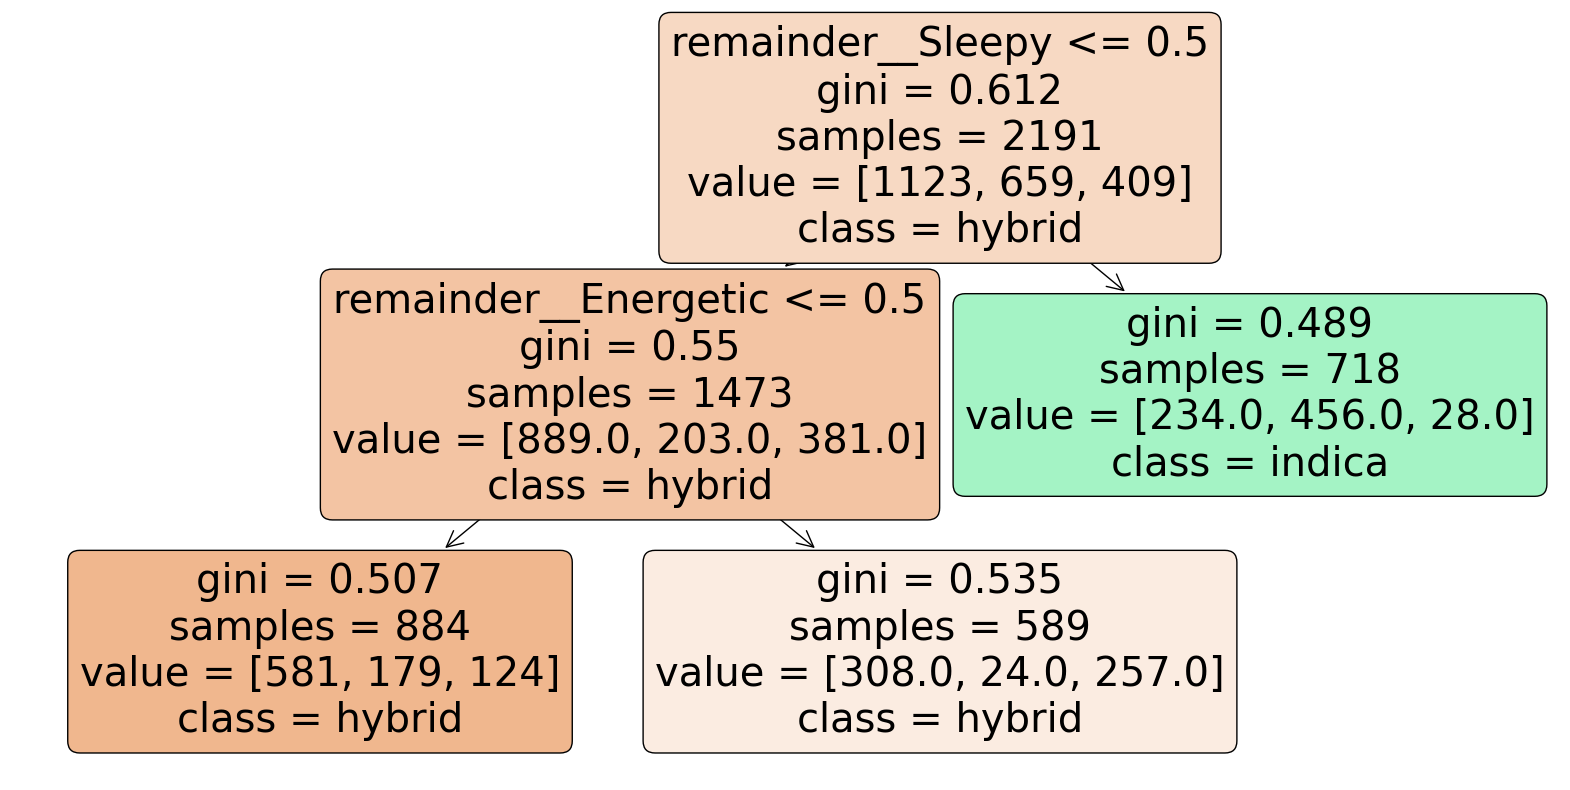

In [170]:
plt.figure(figsize=(20, 10))
plot_tree(dt_pipeline.named_steps['dt'], filled=True, feature_names= feature_names, class_names= class_names, rounded=True)
plt.show()

Using a  min impurity decrease of .01 the model achieved a cross validated accuracy of 61%. The decision tree used sleepiness and energy levels as its main predictors for class. These accuracy results were consistent with the worst model (QDA) in part one.

##### Q2

**LDA**

In [171]:
lda_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("lda", LinearDiscriminantAnalysis())
    ]
).set_output(transform="pandas")

params = {'lda__solver': ['svd', 'lsqr', 'eigen']
          }

grid_search = GridSearchCV(
    lda_pipeline,
    params,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X, y)

best_score = grid_search.best_score_
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")
print(f"Cross-validated Accuracy: {best_score:.2f}")

c:\Users\Evan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Evan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Evan\anaconda3\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Evan\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 475, in fit
    self._final_estimator.fit(Xt, y

Best parameters: {'lda__solver': 'svd'}
Cross-validated Accuracy: 0.56


In [172]:
lda_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("lda", LinearDiscriminantAnalysis(solver='svd', n_components=1))
    ]
).set_output(transform="pandas")

lda_pipeline.fit(X, y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000025F2DC18B30>)])),
                ('lda', LinearDiscriminantAnalysis(n_components=1))])

Confusion Matrix

In [173]:
y_pred_lda = lda_pipeline.predict(X)
conf_matrix = confusion_matrix(y, y_pred_lda)
class_names = ["indica", "sativa", "hybrid"]
conf_matrix_lda = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
conf_matrix_lda

,indica,sativa,hybrid
indica,914,137,72
sativa,241,403,15
hybrid,195,19,195


Unsurprisingly when including all strain types the accuracy decreases, but the magnitude of the decrease was surprising going from 80% to 56%.

**QDA**

In [174]:
qda_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("qda", QuadraticDiscriminantAnalysis())
    ]
).set_output(transform="pandas")

params = {
    'qda__reg_param': [0.0, .001, 0.01, 0.1, 0.5, 1]
}

grid_search = GridSearchCV(
    qda_pipeline,
    params,
    cv=stratified_cv,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X, y)

best_score = grid_search.best_score_
best_params = grid_search.best_params_

print(f"Best parameters: {best_params}")
print(f"Cross-validated Accuracy: {best_score:.2f}")


c:\Users\Evan\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear


Best parameters: {'qda__reg_param': 1}
Cross-validated Accuracy: 0.55


In [175]:
qda_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("qda", QuadraticDiscriminantAnalysis(reg_param=1))
    ]
).set_output(transform="pandas")

qda_pipeline.fit(X, y)

c:\Users\Evan\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000025F2DC18B30>)])),
                ('qda', QuadraticDiscriminantAnalysis(reg_param=1))])

In [176]:
y_pred_qda = qda_pipeline.predict(X)
conf_matrix = confusion_matrix(y, y_pred_qda)
class_names = ["indica", "sativa", "hybrid"]
conf_matrix_qda = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
conf_matrix_qda

,indica,sativa,hybrid
indica,1,785,337
sativa,657,0,2
hybrid,405,4,0


When including hybrid in the QDA it does drop, but by less going from 62% to 55%. While less of a drop it is at the end of the day a bad model for predicting strain.

**KNN**

In [177]:
knn_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("knn", KNeighborsClassifier())
    ]
).set_output(transform="pandas")

params = {'knn__n_neighbors': list(range(1, 100))}

grid_search = GridSearchCV(
    knn_pipeline,
    params,
    cv=stratified_cv,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X, y)

best_n_neighbors = grid_search.best_params_['knn__n_neighbors']
best_accuracy = grid_search.best_score_

print(f"Best n_neighbors: {best_n_neighbors}")
print(f"Best Accuracy: {best_accuracy}")


Best n_neighbors: 98
Best Accuracy: 0.617066600097773


In [178]:
knn_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("knn", KNeighborsClassifier(n_neighbors=35))
    ]
).set_output(transform="pandas")
knn_pipeline.fit(X, y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000025F2DC18B30>)])),
                ('knn', KNeighborsClassifier(n_neighbors=35))])

Confusion Matrix

In [179]:
y_pred_knn = knn_pipeline.predict(X)
conf_matrix = confusion_matrix(y, y_pred_knn)
class_names = ["indica", "sativa", "hybrid"]
conf_matrix_knn = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
conf_matrix_knn

,indica,sativa,hybrid
indica,897,181,45
sativa,238,416,5
hybrid,312,15,82


The new KNN model also faired poorly, when utilizing 98 neighbors the accuracy was 61%.

##### Q3

The metrics in part two were worse, with LDA accuracy facing the biggest hit dropping from 80% to 56%. This is most likely due to having to balancing three variables instead of two. The confusion matrices show hybrid and indica were most often misclassified. I believe this is because there are significantly more indica cases, over a 1000, compared to hybrid with around 400 or sativa around 600. The model likely favors correctly predicting the indica to maximize accuracy since there are so many more cases. This logically leads to misclassification of hybrid and sativa.

### **Part Three: MultiClass from Binary**

##### **Q1 Fit and report metrics for OvR versions of the models. That is, for each of the two model types, create three models:**



In [4]:
myData["Indica"] = (myData["Type"] == "indica").astype('bool')
myData["Sativa"] = (myData["Type"] == "sativa").astype('bool')
myData["Hybrid"] = (myData["Type"] == "hybrid").astype('bool')
y0 = myData["Indica"]
y1 = myData["Sativa"]
y2 = myData["Hybrid"]
Xo = myData.drop(columns=["Indica", "Sativa","Hybrid", "Type"])
#myData

##### **SVC**

In [182]:
svc_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("svc", SVC())  
    ]
).set_output(transform="pandas")

params = {
    'svc__C': [0.1, 1, 10, 100]
}

grid_search = GridSearchCV(
    svc_pipeline,
    params,
    cv=stratified_cv,
    scoring='accuracy',
    n_jobs=-1
)


Indica vs. Not Indica


In [183]:
grid_search.fit(Xo, y0)

best_score = grid_search.best_score_
best_params = grid_search.best_params_

print(f"Best parameters: {best_params}")
print(f"Cross-validated Accuracy: {best_score:.2f}")

Best parameters: {'svc__C': 1}
Cross-validated Accuracy: 0.79


Sativa vs. Not Sativa


In [184]:
grid_search.fit(Xo, y1)

best_score = grid_search.best_score_
best_params = grid_search.best_params_

print(f"Best parameters: {best_params}")
print(f"Cross-validated Accuracy: {best_score:.2f}")

Best parameters: {'svc__C': 10}
Cross-validated Accuracy: 0.82


Hybrid vs. Not Hybrid

In [185]:
grid_search.fit(Xo, y2)

best_score = grid_search.best_score_
best_params = grid_search.best_params_

print(f"Best parameters: {best_params}")
print(f"Cross-validated Accuracy: {best_score:.2f}")

Best parameters: {'svc__C': 1}
Cross-validated Accuracy: 0.63


##### **Logistic Regression**

In [186]:
log_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("logreg", LogisticRegression())
    ]
).set_output(transform="pandas")

params = {
    'logreg__C': [0.01, 0.1, 1, 10, 100]
}

grid_search = GridSearchCV(
    log_pipeline, 
    params, 
    cv=stratified_cv, 
    scoring='accuracy', 
    n_jobs=-1
)

Indica vs. Not Indica


In [187]:
grid_search.fit(Xo, y0)

best_score = grid_search.best_score_
best_params = grid_search.best_params_

print(f"Best parameters: {best_params}")
print(f"Cross-validated Accuracy: {best_score:.2f}")

Best parameters: {'logreg__C': 0.1}
Cross-validated Accuracy: 0.80


Sativa vs. Not Sativa


In [188]:
grid_search.fit(Xo, y1)

best_score = grid_search.best_score_
best_params = grid_search.best_params_

print(f"Best parameters: {best_params}")
print(f"Cross-validated Accuracy: {best_score:.2f}")

Best parameters: {'logreg__C': 1}
Cross-validated Accuracy: 0.83


Hybrid vs. Not Hybrid

In [189]:
grid_search.fit(Xo, y2)

best_score = grid_search.best_score_
best_params = grid_search.best_params_

print(f"Best parameters: {best_params}")
print(f"Cross-validated Accuracy: {best_score:.2f}")

Best parameters: {'logreg__C': 0.1}
Cross-validated Accuracy: 0.63


##### **Q2 Which of the six models did the best job distinguishing the target category from the rest? Which did the worst? Does this make intuitive sense?**



The model that did the best job distinguishing the target category from the rest was logistic regression for sativa vs non sativa at 83% accuracy. The worst model was a tie between SVC and logistic for hybrid vs non hybrid at 63% accuracy. To me this does not make intuitive sense because sativa was a smaller category so i feel like indica vs non indica should predict best since indica was most prevalent. I believe there are strong relationships between the variables that are in play at driving this high accuracy for sativa vs non sativa. Even though hybrid is a mix of indica and sativa I believe that hybrid is closer to indica than sativa allowing the model to see a clear difference between those combined and sativa. This also makes sense for hybrid vs hybrid being the worse since hybrid is a mix of both the models have a hard time distinguishing hybrid vs sativa and indica. 

##### **Q3 Fit and report metrics for OvO versions of the models. That is, for each of the two model types, create three models:**



In [191]:
Data = myData.drop(columns=["Indica", "Sativa", "Hybrid"])
Data1 = Data[(myData["Type"] == "indica") | (myData["Type"] == "sativa")]
Data2 = Data[(myData["Type"] == "indica") | (myData["Type"] == "hybrid")]
Data3 = Data[(myData["Type"] == "hybrid") | (myData["Type"] == "sativa")]

In [192]:
y1 = Data1["Type"]
y2 = Data2["Type"]
y3 = Data3["Type"]
X1 = Data1.drop(columns=["Type"])
X2 = Data2.drop(columns=["Type"])
X3 = Data3.drop(columns=["Type"])

##### **SVC**

In [193]:
svc_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("svc", SVC())  
    ]
).set_output(transform="pandas")

params = {
    'svc__C': [0.1, 1, 10, 100]
}

grid_search = GridSearchCV(
    svc_pipeline,
    params,
    cv=stratified_cv,
    scoring='accuracy',
    n_jobs=-1
)


Indica vs. Sativa

In [194]:
grid_search.fit(X1, y1)

best_score = grid_search.best_score_
best_params = grid_search.best_params_

print(f"Best parameters: {best_params}")
print(f"Cross-validated Accuracy: {best_score:.2f}")

Best parameters: {'svc__C': 10}
Cross-validated Accuracy: 0.86


Indica vs. Hybrid

In [195]:
grid_search.fit(X2, y2)

best_score = grid_search.best_score_
best_params = grid_search.best_params_

print(f"Best parameters: {best_params}")
print(f"Cross-validated Accuracy: {best_score:.2f}")

Best parameters: {'svc__C': 1}
Cross-validated Accuracy: 0.75


Hybrid vs. Sativa

In [196]:
grid_search.fit(X3, y3)

best_score = grid_search.best_score_
best_params = grid_search.best_params_

print(f"Best parameters: {best_params}")
print(f"Cross-validated Accuracy: {best_score:.2f}")

Best parameters: {'svc__C': 100}
Cross-validated Accuracy: 0.75


##### **Logistic Regression**

In [197]:
log_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("logreg", LogisticRegression())
    ]
).set_output(transform="pandas")

params = {
    'logreg__C': [0.01, 0.1, 1, 10, 100]
}

grid_search = GridSearchCV(
    log_pipeline, 
    params, 
    cv=stratified_cv, 
    scoring='accuracy', 
    n_jobs=-1
)

Indica vs. Sativa

In [198]:
grid_search.fit(X1, y1)

best_score = grid_search.best_score_
best_params = grid_search.best_params_

print(f"Best parameters: {best_params}")
print(f"Cross-validated Accuracy: {best_score:.2f}")

Best parameters: {'logreg__C': 0.1}
Cross-validated Accuracy: 0.87


Indica vs. Hybrid

In [199]:
grid_search.fit(X2, y2)

best_score = grid_search.best_score_
best_params = grid_search.best_params_

print(f"Best parameters: {best_params}")
print(f"Cross-validated Accuracy: {best_score:.2f}")

Best parameters: {'logreg__C': 0.1}
Cross-validated Accuracy: 0.77


Hybrid vs. Sativa

In [200]:
grid_search.fit(X3, y3)

best_score = grid_search.best_score_
best_params = grid_search.best_params_

print(f"Best parameters: {best_params}")
print(f"Cross-validated Accuracy: {best_score:.2f}")

Best parameters: {'logreg__C': 1}
Cross-validated Accuracy: 0.75


##### **Q4 Which of the six models did the best job distinguishing at differentiating the two groups? Which did the worst? Does this make intuitive sense?**

The model that did the best job distinguishing the two groups was the logistic regression with a C of 0.1 which gave us a accuracy of 87% for indica vs sativa. The worst model was a three way tie between SVC for indica vs hybrid, hybrid vs sativa, and for SVC hybrid vs sativa at a accuracy of 75%. For the best job this does make intuitive sense because indica and sativa are the most distinct groups so it is logical that they will show the greatest difference allowing the model to predict better. For the worse models a similar intuitive logic follows, inputting hybrid significantly lowers accuracy since the hybrid has traits of both indica and sativa so when comparing any mix that includes hybrid struggles to find differences between the cases. 

##### **Q5 Suppose you had simply input the full data, with three classes, into the LogisticRegression function. Would this have automatically taken an “OvO” approach or an “OvR” approach? What about for SVC?**



When using logistic regression with default parameters it would take on the three classes then use a OVO approach unless you specify "ovr". SVC takes the opposite approach defaulting to "ovr" unless you specify "ovo".